<a href="https://colab.research.google.com/github/KnzMcn/Monkeypox-Using-Autoencoders/blob/main/CAE-CNN_With_Callbacks_Colored.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Another attempt at building an autoencoder as a classifier

# Import the libraries

In [1]:
#if image_dataset_loader is not available uncomment the line below
!pip install image-dataset-loader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import image_dataset_loader

import keras
from keras.models import Model, Sequential
from keras.optimizers import RMSprop
from keras.layers import Input, Dense, Flatten, Dropout, Reshape, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization

from google.colab import drive
import zipfile
import os
from PIL import Image

from sklearn.metrics import classification_report

# Import the dataset

In [3]:
#the commented code below only works on local source, change it as needed
#(X_train, y_train), (X_test, y_test), (X_val, y_val) = image_dataset_loader.load("C:/Users/TOSHIBA_2/Documents/College/3rd - First Sem/Machine Learning/Codes/Learning Evidence/Fold1", ['Train', 'Test', 'Val'])

In [4]:
#using Gdrive to import the dataset into Google Colab
#will ask for authorization
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#if /tmp has contents or repeating Fold1 contents, delete using the line below
#%rm -rf /tmp/Fold1

In [6]:
#unzip the desired folder and extract the contents into the tmp folder
#edit the first one depending on where the zipfile is stored in your Gdrive
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/3rd year/Machine Learning/Learning Evidence/Fold1.zip', 'r') #Opens the file in read mode
zip_ref.extractall('/tmp')
zip_ref.close()

In [7]:
#resize the image for faster processing
#no need to edit the next line, it will just overwrite the original data with the resized data
#but if you're working locally, change it according to the path of the dataset
main_directory = '/tmp/Fold1/Fold1/'

for subdir, dirs, files in os.walk(main_directory):
  for file in files:
    filepath = os.path.join(subdir, file)

    if filepath.endswith('.jpg'):
      im = Image.open(filepath)
      imResize = im.resize((75, 75), Image.ANTIALIAS)
      imResize.save(filepath, 'JPEG', quality=90)

In [8]:
#import the images and divide them according to their folders
#label_test/train/val is for original labels that is without one hot encoding
(X_train, label_train), (X_test, label_test), (X_val, label_val) = image_dataset_loader.load('/tmp/Fold1/Fold1', ['Train', 'Test', 'Val'])

In [9]:
#print the shape of each set
print("X_train shape: {}\nlabel_train shape: {}".format(X_train.shape, label_train.shape))
print("\nX_test shape: {}\nlabel_test shape: {}".format(X_test.shape, label_test.shape))
print("\nX_val shape: {}\nlabel_val shape: {}".format(X_val.shape, label_val.shape))

X_train shape: (2142, 75, 75, 3)
label_train shape: (2142,)

X_test shape: (45, 75, 75, 3)
label_test shape: (45,)

X_val shape: (420, 75, 75, 3)
label_val shape: (420,)


In [10]:
#create dictionary of target classes
label_dict = {
    0: 'Monkeypox',
    1: 'Others'
}

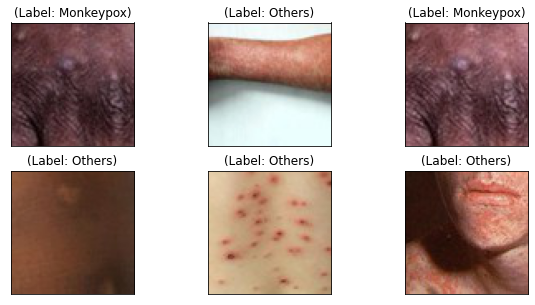

In [11]:
#display images
plt.figure(figsize = [10, 5])

n = 3 #how many images to display
for i in range(n):
    #training images
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X_train[i].reshape(75, 75, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    curr_lbl = label_train[i]
    plt.title("(Label: " + str(label_dict[curr_lbl]) +")")

    #testing images
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(X_test[i].reshape(75, 75, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    curr_lbl = label_test[i]
    plt.title("(Label: " + str(label_dict[curr_lbl]) +")")
plt.show()

In [12]:
#print the labels for each set
print("Labels for label_train: {}".format(label_train[:5]))
print("Labels for label_test: {}".format(label_test[:5]))
print("Labels for label_val: {}".format(label_val[:5]))

Labels for label_train: [0 1 0 1 1]
Labels for label_test: [1 1 1 0 0]
Labels for label_val: [0 1 0 1 0]


# Preprocessing

In [ ]:
#cleaning and reshaping the data
X_train = X_train.astype('float32') / 255
X_train = np.reshape(X_train, (len(X_train), 75, 75, 3))
X_test = X_test.astype('float32') / 255
X_test = np.reshape(X_test, (len(X_test), 75, 75, 3))
X_val = X_val.astype('float32') / 255
X_val = np.reshape(X_val, (len(X_val), 75, 75, 3))

# Convolutional Autoencoder

In [ ]:
#state the hyperparameters of the model
#would need to run a hyperparameter tuning
#increasing powers of two for the batch_size should be used (e.g. 32, 64, 128)
batch_size = 256
epochs = 50
inChannel = 3
x, y = 75, 75
input_img = Input(shape = (x, y, inChannel))
num_classes = 2

In [ ]:
#creating the encoder function
def encoder(input_img):
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding ='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    return x

In [ ]:
#creating the decoder function
def decoder(x):
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    return decoded

In [ ]:
#specifying the loss type
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss = 'mean_squared_error', 
                    optimizer = RMSprop(),
                    metrics = ['accuracy'])

In [ ]:
autoencoder.summary()

# Train the model

In [ ]:
autoencoder_train = autoencoder.fit(X_train,
                                    label_train, 
                                    batch_size = batch_size, 
                                    epochs = epochs,
                                    verbose = 1,
                                    validation_data = (X_val, label_val))

# Visualization

In [ ]:
#plot the loss between training and validation data
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(13)
plt.figure()
plt.plot(epochs, loss, 'b', c = 'blue', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', c = 'orange', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
#save the model
#probably not important since ModelCheckpoint is initialized
#autoencoder.save_weights('autoencoder.h5')

# Classify the images

In [ ]:
#convert labels into one-hot encoding vectors
encoded_train = to_categorical(label_train)
encoded_test = to_categorical(label_test)
encoded_val = to_categorical(label_val)

#display the changes by the one-hot encoding
print('Original label:', label_train[0])
print('After conversion to one-hot:', encoded_train[0])

In [ ]:
#print the shape of each set
print("X_train shape: {}\nencoded_train shape: {}".format(X_train.shape, encoded_train.shape))
print("\nX_test shape: {}\nencoded_test shape: {}".format(X_test.shape, encoded_test.shape))
print("\nX_val shape: {}\nencoded_val shape: {}".format(X_val.shape, encoded_val.shape))

In [ ]:
#define the fully connected layers
def fc(enco):
  flat = Flatten()(enco)
  den = Dense(128, activation='relu')(flat)
  out = Dense(num_classes, activation='softmax')(den)
  return out

In [ ]:
encode = encoder(input_img)
full_model = Model(input_img, fc(encode))

In [ ]:
for l1, l2 in zip(full_model.layers[:19], autoencoder.layers[0:19]):
  l1.set_weights(l2.get_weights())

In [ ]:
#make sure that the weights of the autoencoder is similar with the full model
autoencoder.get_weights()[0][1]

In [ ]:
full_model.get_weights()[0][1]

In [ ]:
#make the encoder untrainable since it is already done
for layer in full_model.layers[0:19]:
  layer.trainable = False

In [ ]:
#compile the model 
full_model.compile(loss = keras.losses.categorical_crossentropy, 
                   optimizer = keras.optimizers.Adam(), 
                   metrics = ['accuracy'])

In [ ]:
#print the summary of the full model
full_model.summary()

# Train the model again

In [ ]:
#define an early stopping callback
#this allows the epoch processing before it overfits
monitor_val_acc = EarlyStopping(monitor = 'val_loss',
                                patience = 7)

In [ ]:
#instantiate a path to save checkpoints
#checkpoint_filepath = '/tmp/checkpoint'

#save the best model made during training
model_checkpoint = ModelCheckpoint('best_full_model.hdf5',
                                   save_weights_only = True,
                                   save_best_only = True)

In [ ]:
classify_train = full_model.fit(X_train, encoded_train, 
                                batch_size = 256, 
                                epochs = 50, 
                                verbose = 1,
                                validation_data = (X_val, encoded_val),
                                callbacks = [monitor_val_acc, model_checkpoint2])

In [ ]:
#forget this line
#save the classification model again
#full_model.save_weights('autoencoder_classification.h5')

In [ ]:
#visualization of the model evaluation
#plot image will change with more epochs
accuracy = classify_train.history['accuracy']
val_accuracy = classify_train.history['val_accuracy']
loss = classify_train.history['loss']
val_loss = classify_train.history['val_loss']
epochs = range(len(accuracy))

#Visualize the accuracy
plt.plot(epochs, accuracy, 'b', c = 'blue', label = 'Training accuracy')
plt.plot(epochs, val_accuracy, 'b', c = 'orange', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.figure()

#Visualize the loss
plt.plot(epochs, loss, 'b', c = 'blue', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', c = 'orange', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Model Evaluation on the Test Set

In [ ]:
test_eval = full_model.evaluate(X_test, encoded_test, verbose = 0)

In [ ]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

# Predict Labels

In [ ]:
predicted_classes = full_model.predict(X_test)

In [ ]:
predicted_classes = np.argmax(np.round(predicted_classes), axis = 1)

In [ ]:
predicted_classes.shape, label_test.shape

In [ ]:
correct = np.where(predicted_classes == label_test)[0]
print('Found %d correct labels' % len(correct) + ' out of %d ' % len(X_test))
for i, correct in enumerate(correct[:9]):
  plt.subplot(3,3, i+1)
  plt.imshow(X_test[correct].reshape(75, 75, 3), interpolation = 'none')
  plt.title('Predicted {}, Class {}'.format(predicted_classes[correct], label_test[correct]))
  plt.tight_layout()

In [ ]:
incorrect = np.where(predicted_classes != label_test)[0]
print('Found %d incorrect labels ' % len(incorrect) + ' out of %d ' % len(X_test))
for i, incorrect in enumerate(incorrect[:9]):
  plt.subplot(3, 3, i+1)
  plt.imshow(X_test[incorrect].reshape(75, 75, 3), interpolation = 'none')
  plt.title('Predicted {}, Class{} '.format(predicted_classes[incorrect], label_test[incorrect]))
  plt.tight_layout()

# Classification Report

In [ ]:
#create a classification report
target_names = ['Class {}'.format(i) for i in range(num_classes)]
print(classification_report(label_test, predicted_classes, target_names = target_names))